<a href="https://colab.research.google.com/github/mag381/AI/blob/main/14_sktime%E3%81%A7%E6%99%82%E7%B3%BB%E5%88%97%E3%83%87%E3%83%BC%E3%82%BF%E3%82%92%E4%BA%88%E6%B8%AC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

sktimeで時系列データを予測してみた<br>
https://dev.classmethod.jp/articles/sktime-time-series-analysis/

In [ ]:
!pip install sktime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.1/16.1 MB 60.8 MB/s eta 0:00:00


In [ ]:
import numpy as np
from sktime.datasets import load_airline
from sktime.forecasting.compose import make_reduction
from sklearn.ensemble import RandomForestRegressor
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.performance_metrics.forecasting import MeanAbsolutePercentageError
import pandas as pd
import matplotlib.pyplot as plt

sktimeに含まれるairlineデータセット。<br>
Box & Jenkinsの航空会社データで、1949年から1960年の各月毎の乗客数のデータ。

In [ ]:
y = load_airline()
print(y)

Period
1949-01    112.0
1949-02    118.0
1949-03    132.0
1949-04    129.0
1949-05    121.0
           ...  
1960-08    606.0
1960-09    508.0
1960-10    461.0
1960-11    390.0
1960-12    432.0
Freq: M, Name: Number of airline passengers, Length: 144, dtype: float64


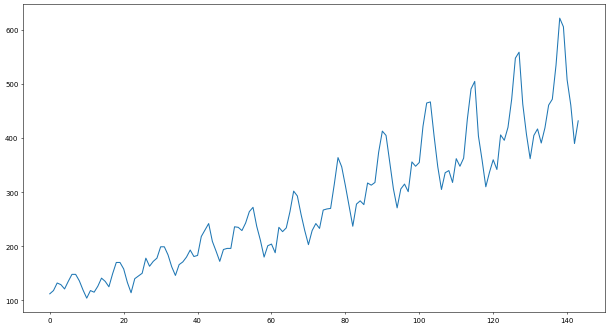

In [ ]:
fig = plt.figure(figsize=(15, 8), dpi=50)
ax1 = plt.axes()
ax1.plot(y.values)

temporal_train_test_splitにより、時系列を考慮したデータ分割を行う。<br>
先頭側をtrain、末尾側をtestに分割する。<br>
デフォルトの場合はtrain:test=3:1で分割される。

In [ ]:
y_train, y_test = temporal_train_test_split(y)

In [ ]:
regressor = RandomForestRegressor()
forecaster = make_reduction(
    regressor,
    strategy="recursive",
    window_length=12,
    scitype="infer",
)
forecaster.fit(y_train)

RecursiveTabularRegressionForecaster(estimator=RandomForestRegressor(),
                                     window_length=12)

In [ ]:
fh = np.arange(1, len(y_test) + 1)  # forecasting horizon
y_pred = forecaster.predict(fh)

In [ ]:
mape = MeanAbsolutePercentageError()
print(f"mape = {mape(y_test, y_pred)}")

mape = 0.13070720020851798


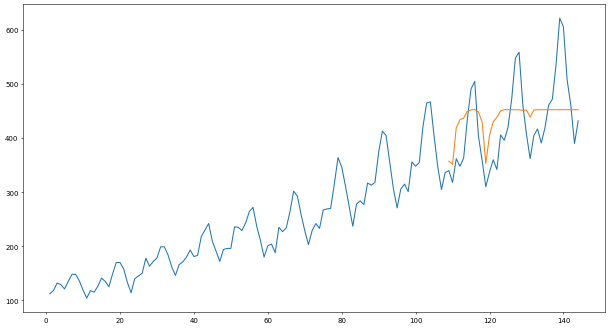

In [ ]:
fig = plt.figure(figsize=(15, 8), dpi=50)
ax1 = plt.axes()
ax1.plot(np.arange(1, len(y) + 1), y.values)
ax1.plot(np.arange(len(y_train)+1, len(y) + 1), y_pred.values)

sktimeでARIMAを使うには、pmdarimaを追加でインストールする必要がある。

In [ ]:
#!poetry add pmdarima # pipなどでも可能
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 23.8 MB/s eta 0:00:00


mape = 0.04356744949188808


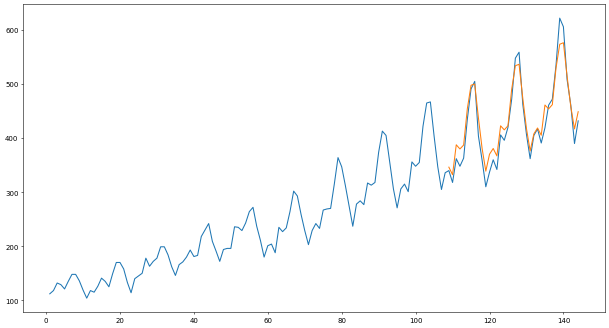

In [ ]:
from sktime.forecasting.arima import ARIMA

forecaster = ARIMA(
    order=(1, 1, 0),
    seasonal_order=(0, 1, 0, 12),
    suppress_warnings=True)
forecaster.fit(y_train)

y_pred = forecaster.predict(fh)

mape = MeanAbsolutePercentageError()
print(f"mape = {mape(y_test, y_pred)}")

fig = plt.figure(figsize=(15, 8), dpi=50)
ax1 = plt.axes()
ax1.plot(np.arange(1, len(y) + 1), y.values)
ax1.plot(np.arange(len(y_train)+1, len(y) + 1), y_pred.values)

ARIMAにはフィルタ次数(p,q)や階数(n)などのパラメータがある。<br>
これを自動探索するAutoARIMAという機能がある。

mape = 0.04148971434138202


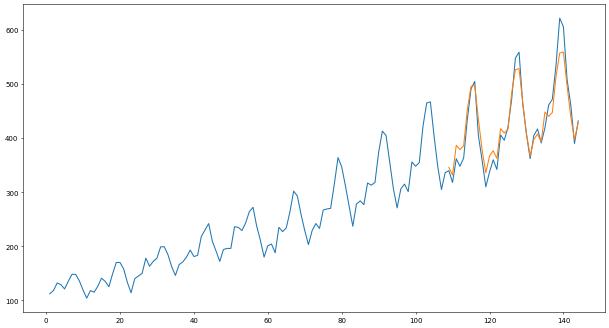

In [ ]:
from sktime.forecasting.arima import AutoARIMA
forecaster = AutoARIMA(sp=12, d=None, max_p=10, max_q=10, suppress_warnings=True)
forecaster.fit(y_train)

y_pred = forecaster.predict(fh)

mape = MeanAbsolutePercentageError()
print(f"mape = {mape(y_test, y_pred)}")

fig = plt.figure(figsize=(15, 8), dpi=50)
ax1 = plt.axes()
ax1.plot(np.arange(1, len(y) + 1), y.values)
ax1.plot(np.arange(len(y_train)+1, len(y) + 1), y_pred.values)

Prophetのモデル式を1から理解する<br>
https://devblog.thebase.in/entry/2019/12/20/110000_1

In [ ]:
#!poetry add prophet # pipなどでも可能
!pip install prophet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# 入力するSeriesのIndexをDatetimeIndexにしておく必要があり
y_train_pp = y_train.to_timestamp(freq="M")
y_train_pp.head(10)

Period
1949-01-31    112.0
1949-02-28    118.0
1949-03-31    132.0
1949-04-30    129.0
1949-05-31    121.0
1949-06-30    135.0
1949-07-31    148.0
1949-08-31    148.0
1949-09-30    136.0
1949-10-31    119.0
Freq: M, Name: Number of airline passengers, dtype: float64

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4fdpw7r0/krc8g6lz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4fdpw7r0/uvmw0lxm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=41634', 'data', 'file=/tmp/tmp4fdpw7r0/krc8g6lz.json', 'init=/tmp/tmp4fdpw7r0/uvmw0lxm.json', 'output', 'file=/tmp/tmp4fdpw7r0/prophet_modelwa2rr_lk/prophet_model-20230405045258.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:52:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
04:52:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.9/dist-packages/sk

mape = 0.07439670457011675


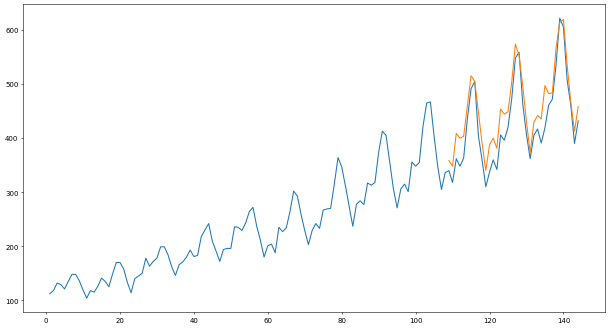

In [ ]:
from sktime.forecasting.fbprophet import Prophet

forecaster = Prophet(
    seasonality_mode='multiplicative',
    n_changepoints=int(len(y) / 12),
    add_country_holidays={'country_name': 'Germany'},
    yearly_seasonality=True)
forecaster.fit(y_train_pp)

y_pred = forecaster.predict(fh)

mape = MeanAbsolutePercentageError()
print(f"mape = {mape(y_test, y_pred)}")

fig = plt.figure(figsize=(15, 8), dpi=50)
ax1 = plt.axes()
ax1.plot(np.arange(1, len(y) + 1), y.values)
ax1.plot(np.arange(len(y_train)+1, len(y) + 1), y_pred.values)